# Discover Symmetry of Rotation (Training)

## Import packages & Mount Drive

In [1]:
import torch as tch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# from google.colab import drive
# import os, sys

# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)

In [3]:
#!ls drive/My\ Drive/Colab\ Notebooks

In [4]:
device = 'cuda' if tch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
pi = tch.tensor(math.pi).float().to(device)
pi

tensor(3.1416)

## Play with Data

In [6]:
# Rotation Data
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X = tch.column_stack([r*tch.cos(th), r*tch.sin(th)])
X

tensor([[ 0.6772,  0.1266],
        [-0.8266, -0.1258],
        [ 0.3311, -0.0576],
        ...,
        [ 0.2549,  0.1432],
        [-0.4066,  0.3487],
        [-0.2068, -0.0185]])

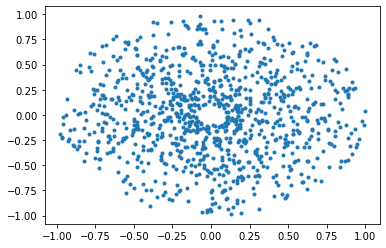

In [7]:
plt.plot(X[:,0].cpu(), X[:,1].cpu(), '.')

In [8]:
# Generate Positive pair
unif = Uniform(0, 2*math.pi)
thetas = unif.sample([1000,]).to(device)
X_p = tch.column_stack([r*tch.cos(th+thetas), r*tch.sin(th+thetas)])
X_p

tensor([[ 6.8845e-01, -2.6596e-02],
        [-4.4106e-01,  7.1033e-01],
        [-2.4859e-01, -2.2615e-01],
        ...,
        [ 2.7075e-01, -1.1029e-01],
        [-3.2772e-01,  4.2368e-01],
        [-2.0767e-01, -4.1077e-04]])

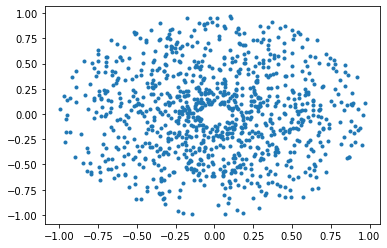

In [9]:
plt.plot(X_p[:,0].cpu(), X_p[:,1].cpu(), '.')

In [10]:
# Generate Negative pair
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X_n = tch.column_stack([r*tch.cos(th), r*tch.sin(th)])
X_n

tensor([[ 0.1777, -0.5382],
        [ 0.5601,  0.1842],
        [ 0.0346, -0.5968],
        ...,
        [ 0.0536,  0.4178],
        [ 0.5925,  0.7081],
        [ 0.4385, -0.3178]])

In [11]:
X_n

tensor([[ 0.1777, -0.5382],
        [ 0.5601,  0.1842],
        [ 0.0346, -0.5968],
        ...,
        [ 0.0536,  0.4178],
        [ 0.5925,  0.7081],
        [ 0.4385, -0.3178]])

In [12]:
# Labeling
y_p = tch.zeros((X_p.shape[0], 1))
y_n = tch.ones((X_n.shape[0], 1))
y = tch.vstack([y_p, y_n])
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

## Implement Dataset

In [13]:
# Implement Dataset
class RotationDataset(Dataset):
    def __init__(self, size):
        unif1 = Uniform(0.1, 1)
        unif2 = Uniform(0, 2*math.pi)
        unif3 = Uniform(0.1, 1)
        unif4 = Uniform(0, 2*math.pi)
        unif5 = Uniform(0, 2*math.pi)

        r1 = unif1.sample([size]).float()
        th1 = unif2.sample([size]).float()
        r2 = unif3.sample([size]).float()
        th2 = unif4.sample([size]).float()
        th3 = unif5.sample([size]).float()

        self.X = tch.column_stack([r1*tch.cos(th1), r1*tch.sin(th1)])
        X_p = tch.column_stack([r1*tch.cos(th1+th3), r1*tch.sin(th1+th3)])
        X_n = tch.column_stack([r2*tch.cos(th2), r2*tch.sin(th2)])

        self.X = tch.vstack([self.X, self.X])
        self.X_pair = tch.vstack([X_p, X_n])

        # Labeling
        y_p = tch.zeros((X_p.shape[0], 1))
        y_n = tch.ones((X_n.shape[0], 1))
        self.y = tch.vstack([y_p, y_n])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = tch.Tensor(self.X[idx])
        x_pair = tch.Tensor(self.X_pair[idx])
        y = tch.Tensor(self.y[idx])
        return x, x_pair, y

## Implement Siamese Network

In [14]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

## Implement Contrastive Loss (Hadsell)

In [15]:
class ContrastiveLoss(tch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = tch.mean((1-label) * tch.pow(euclidean_distance, 2) +
                                      (label) * tch.pow(tch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

## Declare Model, Loss and Optimizer

In [16]:
net = SNN().to(device)
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [17]:
loss_fn = ContrastiveLoss()
optimizer = tch.optim.Adam(net.parameters(), lr=0.01)
scheduler = tch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

## Make Dataset & Dataloader

In [18]:
train_dataset = RotationDataset(100000)
valid_dataset = RotationDataset(10000)
test_dataset = RotationDataset(10000)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [20]:
for _, samples in enumerate(test_dataloader):
    x, x_p, y = samples
    temp = tch.column_stack([x, x_p, y])
    print(temp[:5, :])
    break

tensor([[-0.2197, -0.1908, -0.0799,  0.2798,  0.0000],
        [-0.1246,  0.2646, -0.2381,  0.1699,  0.0000],
        [ 0.9037, -0.1178, -0.5517, -0.7253,  0.0000],
        [-0.4268, -0.1812,  0.0971,  0.4534,  0.0000],
        [ 0.0378, -0.1773, -0.1767,  0.0403,  0.0000]])


## Train & Validate

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    for batch, samples in enumerate(dataloader):
        X, X_p, y = samples
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)

        pred1, pred2 = model(X, X_p)
        loss = loss_fn(pred1, pred2, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+100) * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_loss.append(loss)
        
    return tch.mean(tch.tensor(train_loss).float().to(device))

In [22]:
def validity_check(dataloader, model, loss_fn, dist=1):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with tch.no_grad():
        for X, X_p, y in dataloader:
            X, X_p, y = X.to(device), X_p.to(device), y.to(device)
            pred1, pred2 = model(X, X_p)
            test_loss += loss_fn(pred1, pred2, y).item()
            correct += tch.count_nonzero((tch.abs(pred1 - pred2) <= dist) != y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [23]:
epochs = 500
train_loss= []
valid_loss = []
lr = 0.01
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, net, loss_fn, optimizer))
    validity, correct = validity_check(valid_dataloader, net, loss_fn, 0.2)
    valid_loss.append(validity)
    scheduler.step(validity)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(f" Learning Rate: {lr:>8f}")
    if lr < 1e-6:
        break
    if correct == 1:
        break
print("Done!")


Epoch 1
-------------------------------
loss: 1.966954  [50000/200000]
loss: 0.752122  [100000/200000]
loss: 0.196434  [150000/200000]
loss: 0.172655  [200000/200000]
Validation Error: 
 Accuracy: 95.7%, Avg loss: 0.141209
 Learning Rate: 0.010000

Epoch 2
-------------------------------
loss: 0.160808  [50000/200000]
loss: 0.140549  [100000/200000]
loss: 0.119078  [150000/200000]
loss: 0.156182  [200000/200000]
Validation Error: 
 Accuracy: 99.3%, Avg loss: 0.094486
 Learning Rate: 0.010000

Epoch 3
-------------------------------
loss: 0.133132  [50000/200000]
loss: 0.093179  [100000/200000]
loss: 0.106878  [150000/200000]
loss: 0.083499  [200000/200000]
Validation Error: 
 Accuracy: 89.4%, Avg loss: 0.088022
 Learning Rate: 0.010000

Epoch 4
-------------------------------
loss: 0.107027  [50000/200000]
loss: 0.081622  [100000/200000]
loss: 0.099066  [150000/200000]
loss: 0.086056  [200000/200000]
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.071516
 Learning Rate: 0.010000

Epo

loss: 0.032717  [100000/200000]
loss: 0.033565  [150000/200000]
loss: 0.038228  [200000/200000]
Validation Error: 
 Accuracy: 99.8%, Avg loss: 0.027471
 Learning Rate: 0.010000

Epoch 35
-------------------------------
loss: 0.028353  [50000/200000]
loss: 0.022394  [100000/200000]
loss: 0.046293  [150000/200000]
loss: 0.025507  [200000/200000]
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.029530
 Learning Rate: 0.010000

Epoch 36
-------------------------------
loss: 0.029990  [50000/200000]
loss: 0.039180  [100000/200000]
loss: 0.026903  [150000/200000]
loss: 0.041478  [200000/200000]
Validation Error: 
 Accuracy: 96.9%, Avg loss: 0.031893
 Learning Rate: 0.010000

Epoch 37
-------------------------------
loss: 0.026073  [50000/200000]
loss: 0.032315  [100000/200000]
loss: 0.026636  [150000/200000]
loss: 0.017375  [200000/200000]
Validation Error: 
 Accuracy: 86.3%, Avg loss: 0.042401
 Learning Rate: 0.010000

Epoch 38
-------------------------------
loss: 0.042967  [50000/200000]


loss: 0.012154  [100000/200000]
loss: 0.049131  [150000/200000]
loss: 0.014046  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020895
 Learning Rate: 0.001000

Epoch 68
-------------------------------
loss: 0.009028  [50000/200000]
loss: 0.026327  [100000/200000]
loss: 0.026305  [150000/200000]
loss: 0.016317  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020868
 Learning Rate: 0.001000

Epoch 69
-------------------------------
loss: 0.006626  [50000/200000]
loss: 0.018004  [100000/200000]
loss: 0.034080  [150000/200000]
loss: 0.019050  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020809
 Learning Rate: 0.001000

Epoch 70
-------------------------------
loss: 0.019588  [50000/200000]
loss: 0.022519  [100000/200000]
loss: 0.009437  [150000/200000]
loss: 0.018999  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.021319
 Learning Rate: 0.001000

Epoch 71
-------------------------------
loss: 0.026540  [50000/200000]


loss: 0.015486  [100000/200000]
loss: 0.037793  [150000/200000]
loss: 0.030373  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020390
 Learning Rate: 0.000001

Epoch 101
-------------------------------
loss: 0.045447  [50000/200000]
loss: 0.021982  [100000/200000]
loss: 0.044010  [150000/200000]
loss: 0.026123  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020389
 Learning Rate: 0.000001

Epoch 102
-------------------------------
loss: 0.019681  [50000/200000]
loss: 0.024831  [100000/200000]
loss: 0.025120  [150000/200000]
loss: 0.020819  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020395
 Learning Rate: 0.000001

Epoch 103
-------------------------------
loss: 0.023920  [50000/200000]
loss: 0.010529  [100000/200000]
loss: 0.018796  [150000/200000]
loss: 0.035114  [200000/200000]
Validation Error: 
 Accuracy: 99.9%, Avg loss: 0.020390
 Learning Rate: 0.000001

Epoch 104
-------------------------------
loss: 0.021506  [50000/2000

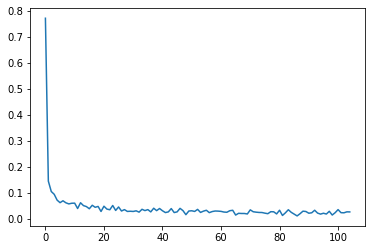

In [24]:
plt.plot(train_loss)

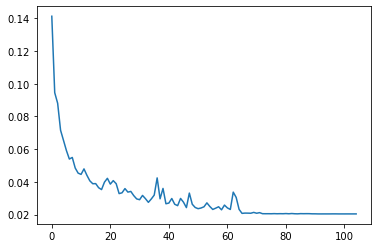

In [25]:
plt.plot(valid_loss)

## Print Result & Save Model

In [26]:
with tch.no_grad():
    for X, X_p, y in test_dataloader:
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)
        pred1, pred2 = net(X, X_p)
        data = tch.column_stack([pred1, pred2, y])
        print(data[:10,:])
        break

tensor([[ 41.1475,  41.1542,   0.0000],
        [ 41.3520,  41.3701,   0.0000],
        [129.0854, 129.0965,   0.0000],
        [ 65.6219,  65.6387,   0.0000],
        [ 25.6031,  25.5977,   0.0000],
        [ 48.9678,  48.9602,   0.0000],
        [ 57.6010,  57.5957,   0.0000],
        [ 63.0676,  63.0653,   0.0000],
        [139.1700, 139.1344,   0.0000],
        [ 73.1325,  73.1189,   0.0000]])


In [27]:
tch.save(net, "model/snn_rot8.pt")